In [2]:
import math
import meep as mp
from meep import mpb

import numpy as np
import matplotlib.pyplot as plt

In [15]:
#屈折率
n_Air = 1
n_Si = 2.6
r = 0.14


#計算する固有周波数の数
num_bands = 6

#メッシュの細かさ
resolution = 32

#単位格子
geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1),
                              basis1=mp.Vector3(math.sqrt(3)/2, 0.5),
                              basis2=mp.Vector3(math.sqrt(3)/2, -0.5))

#構造
#default_material = mp.Medium(epsilon=n_Si**2)
geometry = [
            mp.Block(material=mp.Medium(epsilon=n_Si**2),
                        size=mp.Vector3(mp.inf, mp.inf)),
            mp.Cylinder(r, center=mp.Vector3(1 / 6, 1 / 6), height=mp.inf,
                        material=mp.Medium(epsilon=n_Air**2)),
            mp.Cylinder(r, center=mp.Vector3(1 / -6, 1 / -6), height=mp.inf,
                        material=mp.Medium(epsilon=n_Air**2))
           ]


#ブリルアンゾーン
k_points = [
    mp.Vector3(),               # Gamma
    mp.Vector3(y=0.5),          # M
    mp.Vector3(-1./3, 1./3),    # K
    mp.Vector3(),               # Gamma
]
k_points = mp.interpolate(4, k_points)

In [16]:
#計算
ms = mpb.ModeSolver(
    geometry=geometry,
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

ms.run_tm(mpb.output_at_kpoint(mp.Vector3(-1./3, 1./3),
                               mpb.fix_efield_phase,
                               mpb.output_efield_z))
tm_freqs = ms.all_freqs
tm_gaps = ms.gap_list
ms.run_te()
te_freqs = ms.all_freqs
te_gaps = ms.gap_list

Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.866025, 0.5, 0)
     (0.866025, -0.5, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (0.57735, 1, -0)
     (0.57735, -1, 0)
     (-0, 0, 1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.166667,0.166667,0)
          radius 0.14, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.166667,-0.166667,0)
          radius 0.14, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: tm.
Initializing fields to random numbers...
16 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.0, 0.1, 0.0>
  Vector3<0.0, 0.2, 

Solving for bands 2 to 6...
Finished solving for bands 2 to 6 after 13 iterations.
tefreqs:, 1, 0, 0, 0, 0, 0, 0.449103, 0.457009, 0.482864, 0.482962, 0.546193
elapsed time for k point: 0.06712985038757324
solve_kpoint (0,0.1,0):
Solving for bands 1 to 6...
Finished solving for bands 1 to 6 after 72 iterations.
tefreqs:, 2, 0, 0.1, 0, 0.11547, 0.0493878, 0.427458, 0.443635, 0.478998, 0.501244, 0.55309
elapsed time for k point: 0.15055370330810547
solve_kpoint (0,0.2,0):
Solving for bands 1 to 6...
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 3, 0, 0.2, 0, 0.23094, 0.0986961, 0.387705, 0.423599, 0.470976, 0.531535, 0.570126
elapsed time for k point: 0.035811424255371094
solve_kpoint (0,0.3,0):
Solving for bands 1 to 6...
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 4, 0, 0.3, 0, 0.34641, 0.147804, 0.342544, 0.408104, 0.463384, 0.564395, 0.592674
elapsed time for k point: 0.03416037559509277
solve_kpoint (0,0.4,0):
Solving for bands 1 to 6...
Finishe

In [17]:
md = mpb.MPBData(rectify=True, periods=5, resolution=64)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
converted_eps.shape

epsilon: 1-6.76, mean 5.94096, harm. mean 3.92455, 89.8438% > 1, 85.7805% "fill"


(320, 277)

In [18]:
import csv
with open('epsilon_distribution.csv', 'wt') as f:
    writer = csv.writer(f)
    writer.writerows(converted_eps)

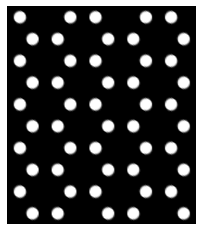

In [19]:
plt.imshow(converted_eps, interpolation='spline36', cmap="binary")
plt.axis('off')
plt.show()

In [20]:
tm_freqs.max()

0.6007543801215993

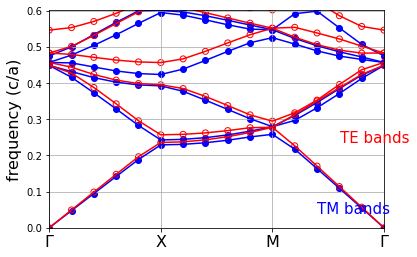

In [21]:
fig, ax = plt.subplots()

x = range(len(tm_freqs))

# Plot bands
# Scatter plot for multiple y values, see https://stackoverflow.com/a/34280815/2261298
for xz, tmz, tez in zip(x, tm_freqs, te_freqs):
    ax.scatter([xz]*len(tmz), tmz, color='blue')
    ax.scatter([xz]*len(tez), tez, color='red', facecolors='none')
ax.plot(tm_freqs, color='blue')
ax.plot(te_freqs, color='red')
ax.set_ylim([tm_freqs.min(), tm_freqs.max()])
ax.set_xlim([x[0], x[-1]])

# Plot gaps
for gap in tm_gaps:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='blue', alpha=0.2)

for gap in te_gaps:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='red', alpha=0.2)


# Plot labels
ax.text(12, 0.04, 'TM bands', color='blue', size=15)
ax.text(13.05, 0.235, 'TE bands', color='red', size=15)

points_in_between = (len(tm_freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'X', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=16)
ax.set_ylabel('frequency (c/a)', size=16)
ax.grid(True)

plt.show()

Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.866025, 0.5, 0)
     (0.866025, -0.5, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (0.57735, 1, -0)
     (0.57735, -1, 0)
     (-0, 0, 1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.166667,0.166667,0)
          radius 0.14, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.166667,-0.166667,0)
          radius 0.14, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
16 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.0, 0.1, 0.0>
  Vector3<0.0, 0.2, 0.0>
  Vector3<0.0, 0

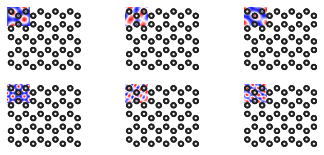

In [22]:
efields = []

def get_efields(ms, band):
    efields.append(ms.get_efield(band, bloch_phase=True))

ms.run_tm(mpb.output_at_kpoint(mp.Vector3(1 / -3, 1 / 3), mpb.fix_efield_phase,
          get_efields))

# Create an MPBData instance to transform the efields
md = mpb.MPBData(rectify=True, resolution=32, periods=3)

converted = []
for f in efields:
    # Get just the z component of the efields
    f = f[..., 0, 2]
    converted.append(md.convert(f))

for i, f in enumerate(converted):
    plt.subplot(331 + i)
    plt.contour(converted_eps.T, cmap='binary')
    plt.imshow(np.real(f).T, interpolation='spline36', cmap='bwr', alpha=0.9)
    plt.axis('off')

plt.show()

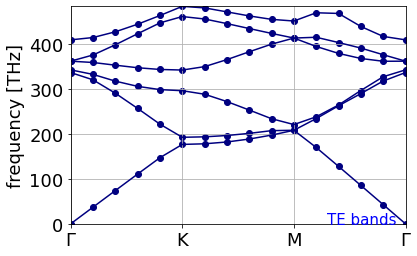

In [23]:
#THz表示
a = 400
c_const = 299792458

fontsize = 18
te_freqs_THz = np.array(te_freqs) * c_const/(a*10**3)
te_gaps_THz = np.array(te_gaps) * c_const/(a*10**3)
#print(te_freqs_THz)

fig, ax = plt.subplots()

x = range(len(te_freqs))

for xz, tez in zip(x, te_freqs_THz):
    ax.scatter([xz]*len(tez), tez, color='navy')

ax.plot(te_freqs_THz, color='navy')
ax.set_ylim([te_freqs_THz.min(), te_freqs_THz.max()])
ax.set_xlim([x[0], x[-1]])

for gap in te_gaps_THz:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='blue', alpha=0.2)

ax.text(11.5, 0, 'TE bands', color='blue', size=15)

points_in_between = (len(te_freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'K', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=fontsize)
ax.set_ylabel('frequency [THz]', size=fontsize)
plt.tick_params(labelsize=fontsize)
ax.grid(True)

plt.show()